In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split
import evaluation
import strategy

In [5]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data['price'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))
price = data[['price']]

In [7]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5610, 19, 1)
y_train.shape =  (5610, 1)
x_test.shape =  (1403, 19, 1)
y_test.shape =  (1403, 1)


In [9]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [12]:
import time

input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 300

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)

start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_tensor)
    y_test_pred = model(x_test_tensor)

    train_loss = criterion(y_train_pred, y_train_lstm)
    test_loss = criterion(y_test_pred, y_test_lstm)

    print(f"Epoch {t}: Train MSE: {train_loss.item()}, Test MSE: {test_loss.item()}")
    train_losses[t] = train_loss.item()
    test_losses[t] = test_loss.item()

    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch 0: Train MSE: 0.6136925220489502, Test MSE: 0.1180424615740776
Epoch 1: Train MSE: 0.24346691370010376, Test MSE: 0.25781744718551636


KeyboardInterrupt: 

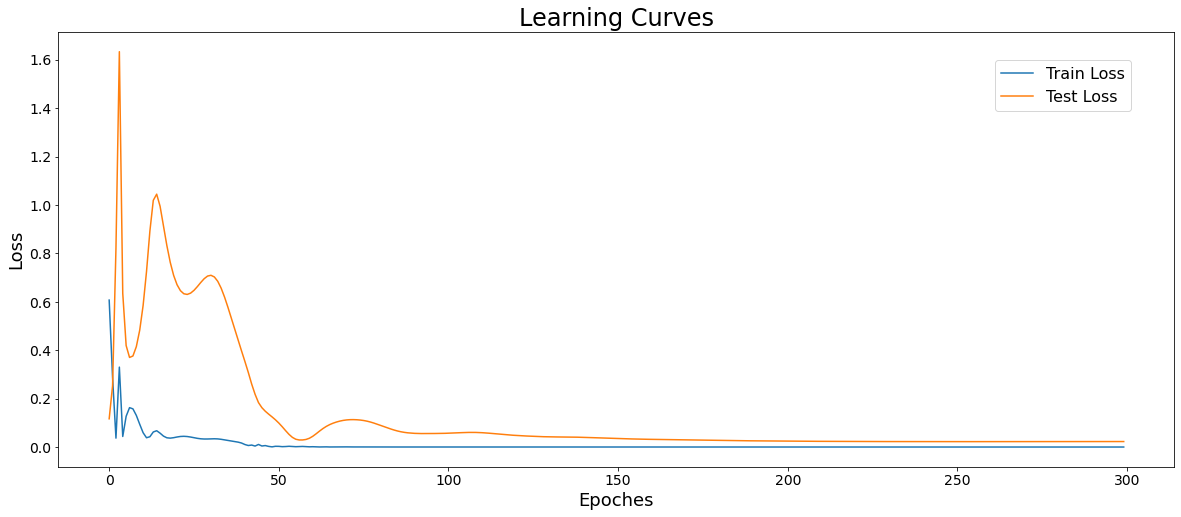

In [191]:
fig = plt.figure(figsize=(20,8))

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")

plt.legend(loc='lower center', bbox_to_anchor=(0.9, 0.8), fontsize=16)

plt.title('Learning Curves', fontsize=24)
plt.xlabel('Epoches', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [195]:
torch.save(model.state_dict(), 'models/lstm1')

# Load and Evaluate Model

In [13]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.load_state_dict(torch.load('models/lstm1'))

<All keys matched successfully>

In [15]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_train_pred = model(x_train_tensor)
y_test_pred = model(x_test_tensor)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.64 RMSE
Test Score: 26.03 RMSE


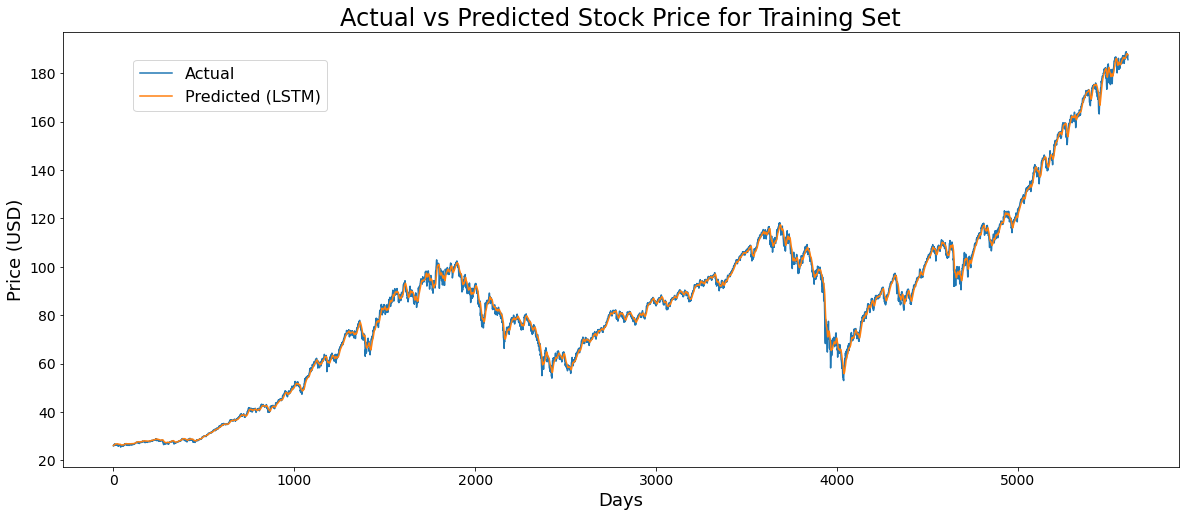

In [31]:
predict = pd.DataFrame(y_train_pred)
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

plt.figure(figsize=(20,8))
plt.plot(original.index, original[0], label="Actual")
plt.plot(predict.index, predict[0], label="Predicted (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Actual vs Predicted Stock Price for Training Set', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

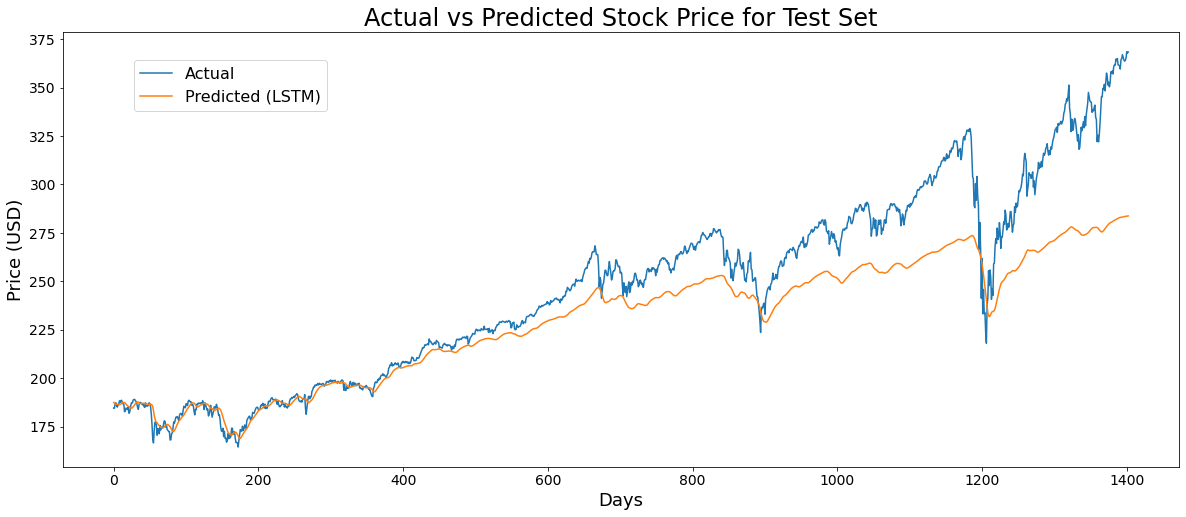

In [32]:
y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

plt.figure(figsize=(20,8))
plt.plot(y_test.index, y_test[0], label="Actual")
plt.plot(y_test_pred.index, y_test_pred[0], label="Predicted (LSTM)")

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.8), fontsize=16)

plt.title('Actual vs Predicted Stock Price for Test Set', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [18]:
actual_change = (y_test.shift(-1) - y_test) / y_test
pred_change = (y_test_pred.shift(-1) - y_test_pred) / y_test_pred
label_pred = pred_change > 0
label_actual = actual_change > 0
label = label_pred == label_actual
label.value_counts()

True     715
False    688
dtype: int64

In [19]:
changes = []
for idx, change in enumerate(pred_change[:-1].to_numpy().reshape(-1)):
    if change > 0:
        print(f"[{idx}] \t BUY: {change}")
    elif change < 0:
        print(f"[{idx}] \t SELL: {change}")
    changes.append(change)
pd.DataFrame(changes).describe()

[0] 	 SELL: -0.0017413387540727854
[1] 	 SELL: -0.0019501391798257828
[2] 	 SELL: -0.0010117033962160349
[3] 	 SELL: -7.934302993817255e-05
[4] 	 SELL: -0.00011068004096159711
[5] 	 SELL: -0.0005456893122754991
[6] 	 SELL: -0.00037793448427692056
[7] 	 SELL: -7.034188456600532e-05
[8] 	 BUY: 0.0008788849809207022
[9] 	 BUY: 0.0010777587303891778
[10] 	 BUY: 0.001424212590791285
[11] 	 BUY: 0.0015305752167478204
[12] 	 BUY: 0.0009401019779033959
[13] 	 BUY: 0.0002570314100012183
[14] 	 SELL: -0.00017988390754908323
[15] 	 SELL: -0.0019086592365056276
[16] 	 SELL: -0.0027300058864057064
[17] 	 SELL: -0.002279787790030241
[18] 	 SELL: -0.0018013390945270658
[19] 	 SELL: -0.001598787377588451
[20] 	 SELL: -0.0009422352886758745
[21] 	 SELL: -0.0017404361860826612
[22] 	 SELL: -0.0020478912629187107
[23] 	 SELL: -0.0010561299277469516
[24] 	 BUY: 0.0005289955297484994
[25] 	 BUY: 0.0017211793456226587
[26] 	 BUY: 0.0021775977220386267
[27] 	 BUY: 0.0027633619029074907
[28] 	 BUY: 0.00297391

,0
count,1402.000000
mean,0.000298
std,0.002088
min,-0.015085
25%,-0.000365
50%,0.000594
75%,0.001310
max,0.007679


In [20]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [21]:
accuracy_score(label_actual, label_pred)

0.5096222380612973

In [22]:
precision_score(label_actual, label_pred)

0.5464994775339603

In [23]:
recall_score(label_actual, label_pred)

0.6731016731016731

In [24]:
def mark(row):
    if row['change'] > 0:
        return 'B'
    elif row['change'] < 0:
        return 'S'
    else:
        return 'H'

lstmd = data[-1403:-1]
lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)
lstmd

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_62626/1067080769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['change'] = pred_change[:-1].to_numpy().reshape(-1)
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_62626/1067080769.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstmd['action'] = lstmd.apply(lambda row: mark(row), axis=1)


,Open,High,Low,Close,Volume,price,change,action
Date,,,,,,,,
2015-06-09,184.456467,185.031657,183.783951,184.456467,105034700,-0.077574,-0.001741,S
2015-06-10,185.270565,187.075759,185.208629,186.668701,134551300,-0.064744,-0.001950,S
2015-06-11,187.137659,187.677445,186.889889,187.270401,73876400,-0.061254,-0.001012,S
2015-06-12,186.394387,187.137696,185.544882,185.836899,135382400,-0.069568,-0.000079,S
2015-06-15,184.624564,185.341327,183.872398,185.040466,124384200,-0.074187,-0.000111,S
...,...,...,...,...,...,...,...,...
2020-12-23,364.712299,366.039314,363.662570,364.009186,46201400,0.963759,0.000264,B
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,0.971972,0.000159,B
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,0.990179,0.000105,B


In [25]:
lstm_perf = evaluation.eval(lstmd)

Performance: 81.4%


In [26]:
macd_perf = evaluation.eval(strategy.macd(data))

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Performance: 176.58%


In [27]:
bh_perf = evaluation.eval(strategy.bh(data))

Performance: 98.84%


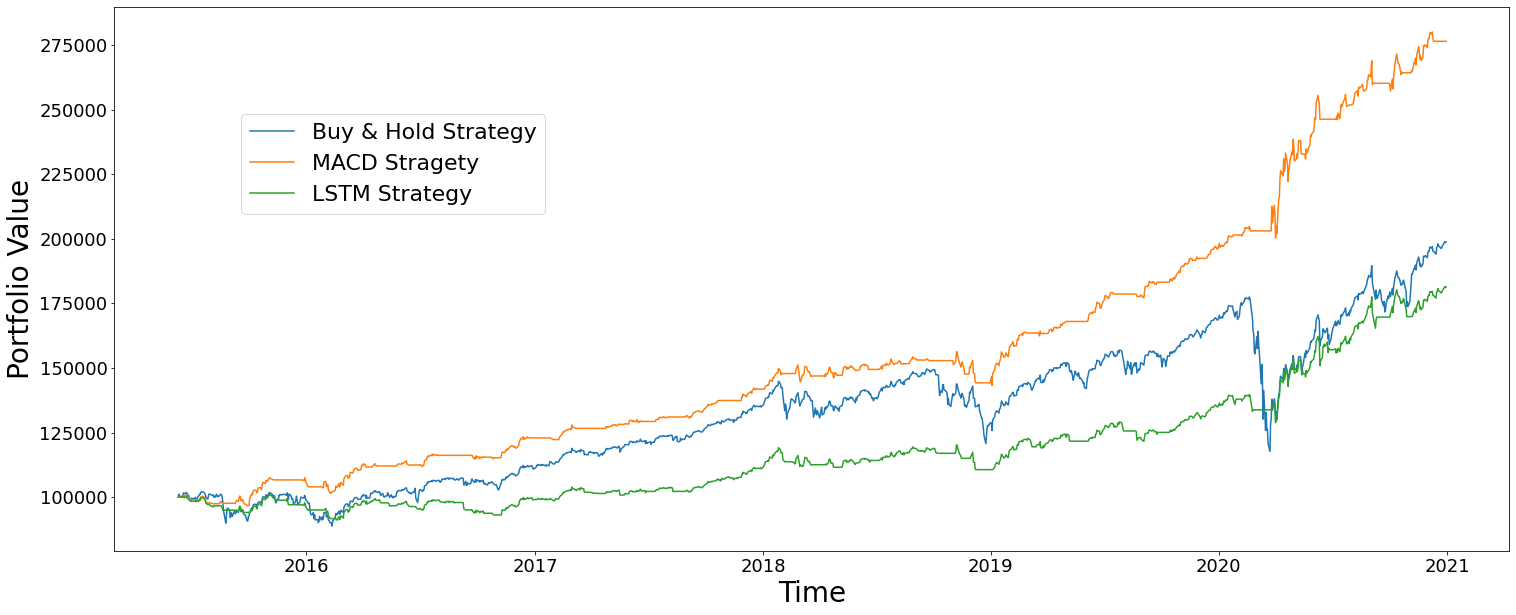

In [28]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['value'], label='Buy & Hold Strategy')
plt.plot(macd_perf['value'], label='MACD Stragety')
plt.plot(lstm_perf['value'], label='LSTM Strategy')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Portfolio Value', fontsize=28)

plt.show()

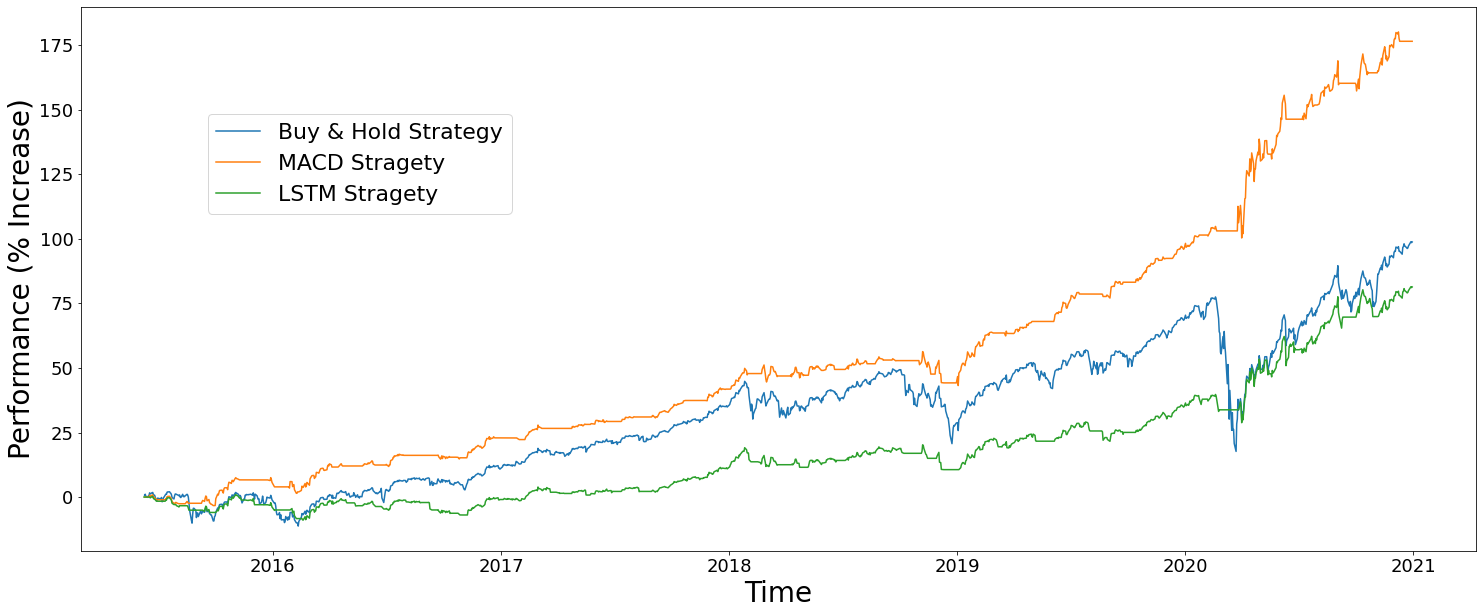

In [29]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['percentage'], label='Buy & Hold Strategy')
plt.plot(macd_perf['percentage'], label='MACD Stragety')
plt.plot(lstm_perf['percentage'], label='LSTM Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Performance (% Increase)', fontsize=28)

plt.show()

In [30]:
bh_perf.to_csv('evals/bh.csv')
macd_perf.to_csv('evals/macd.csv')
lstm_perf.to_csv('evals/lstm.csv')